Please document your approach to this assignment in the cell below.

## Documentation

#### Preprocessing

The main component of the preprocessing was the reshaping of the test and score sets. This involved grabbing a chunk of the code from the `frame_to_nd_array` function for the score set since the function takes in a set of y values, which we don't have.
    
#### Architecture

From the initial archetecture from the template, I started by increasing the complexity until there were around 50k total parameters. Initially, I had 5 GRUs with 64, 48, 32, 32, and 16 units prior to the dense layer. By comparing the loss and validation loss values while training, I was able to diagnose overfitting to an extent. I eventually settled on the below architecture: 4 GRUs (64, 48, 32, and 16 units), each containing kernel, bias, and recurrent l1 regularizers with a regularization parameter of 0.01. For the training process, the main modification that I made was increasing the number of overall training epochs such that the ReduceLROnPlateau callback function would have sufficient iterations to actually make modifications to the learning rate in the case that learning stagnated. I also tweaked the baseline learning rate on the Adam optimizer based on the some learning curves that I plotted.

In [1]:
# This cell fixes an issue with Tensorflow/Keras and GRU on GPU.
!bash -l -c "conda activate ucla_deeplearning && pip install numpy==1.19.5"

     |████████████████████████████████| 14.9 MB 5.9 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.2.0 requires scipy==1.4.1; python_version >= "3", but you have scipy 1.7.1 which is incompatible.
tensorflow 2.2.0 requires tensorboard<2.3.0,>=2.2.0, but you have tensorboard 2.4.0 which is incompatible.
tensorflow 2.2.0 requires tensorflow-estimator<2.3.0,>=2.2.0, but you have tensorflow-estimator 2.6.0 which is incompatible.


In [1]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
    
# tf.config.experimental.set_visible_devices([], 'GPU')
# tf.debugging.set_log_device_placement(True)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2021-10-15 20:07:22.525229: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-15 20:07:22.691123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-15 20:07:22.692033: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-15 20:07:22.970128: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-15 20:07:26.435220: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-15 20:07:28.524175: I tensorflow/stream_executor/platform/defaul

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')

Matplotlib is building the font cache; this may take a moment.


In [3]:
%%capture
prefix = 'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/weather/jobs/transform_batch/20200927-010303_94e076593fe6eeb97c0a5f442b4198dc'

train_X = pd.read_parquet(f'{prefix}/train_x.parquet')
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')

validate_X = pd.read_parquet(f'{prefix}/validate_x.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')

test_X = pd.read_parquet(f'{prefix}/test_x.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

score_X = pd.read_parquet(f'{prefix}/score_x.parquet')

condition_window = 24
prediction_window = 24
features_length = 4

In [4]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 826464 entries, ('Albuquerque/1108/0', Timestamp('2015-02-16 09:00:00')) to ('Vancouver/806/12', Timestamp('2014-07-03 04:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   temperature  826464 non-null  float64
 1   humidity     826464 non-null  float64
 2   pressure     826464 non-null  float64
 3   wind_speed   826464 non-null  float64
dtypes: float64(4)
memory usage: 32.3+ MB


In [5]:
score_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 57576 entries, ('Albuquerque/2249/0', Timestamp('2017-07-15 13:00:00')) to ('Vancouver/2623/10', Timestamp('2017-07-07 20:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  57576 non-null  float64
 1   humidity     57576 non-null  float64
 2   pressure     57576 non-null  float64
 3   wind_speed   57576 non-null  float64
dtypes: float64(4)
memory usage: 2.2+ MB


In [6]:
train_X.head()

temperature  humidity  pressure  \
sample             time                                                   
Albuquerque/1108/0 2015-02-16 09:00:00   276.323000      47.0    1031.0   
                   2015-02-16 10:00:00   275.097667      45.0    1032.0   
                   2015-02-16 11:00:00   273.931333      48.0    1032.0   
                   2015-02-16 12:00:00   274.380000      46.0    1033.0   
                   2015-02-16 13:00:00   272.675333      51.0    1033.0   

                                        wind_speed  
sample             time                             
Albuquerque/1108/0 2015-02-16 09:00:00         3.0  
                   2015-02-16 10:00:00         3.0  
                   2015-02-16 11:00:00         2.0  
                   2015-02-16 12:00:00         2.0  
                   2015-02-16 13:00:00         1.0

In [7]:
train_X.groupby('sample').size().head()

sample
Albuquerque/1108/0    24
Albuquerque/1108/1    24
Albuquerque/1108/2    24
Albuquerque/1112/0    24
Albuquerque/1112/1    24
dtype: int64

In [8]:
train_X.loc['Albuquerque/1112/1'].head()

,temperature,humidity,pressure,wind_speed
time,,,,
2015-02-20 18:00:00,282.116500,46.0,1023.0,3.0
2015-02-20 19:00:00,287.061667,40.0,1021.0,4.0
2015-02-20 20:00:00,288.236333,38.0,1019.0,4.0
2015-02-20 21:00:00,286.928000,35.0,1020.0,4.0
2015-02-20 22:00:00,288.930333,34.0,1017.0,5.0


/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


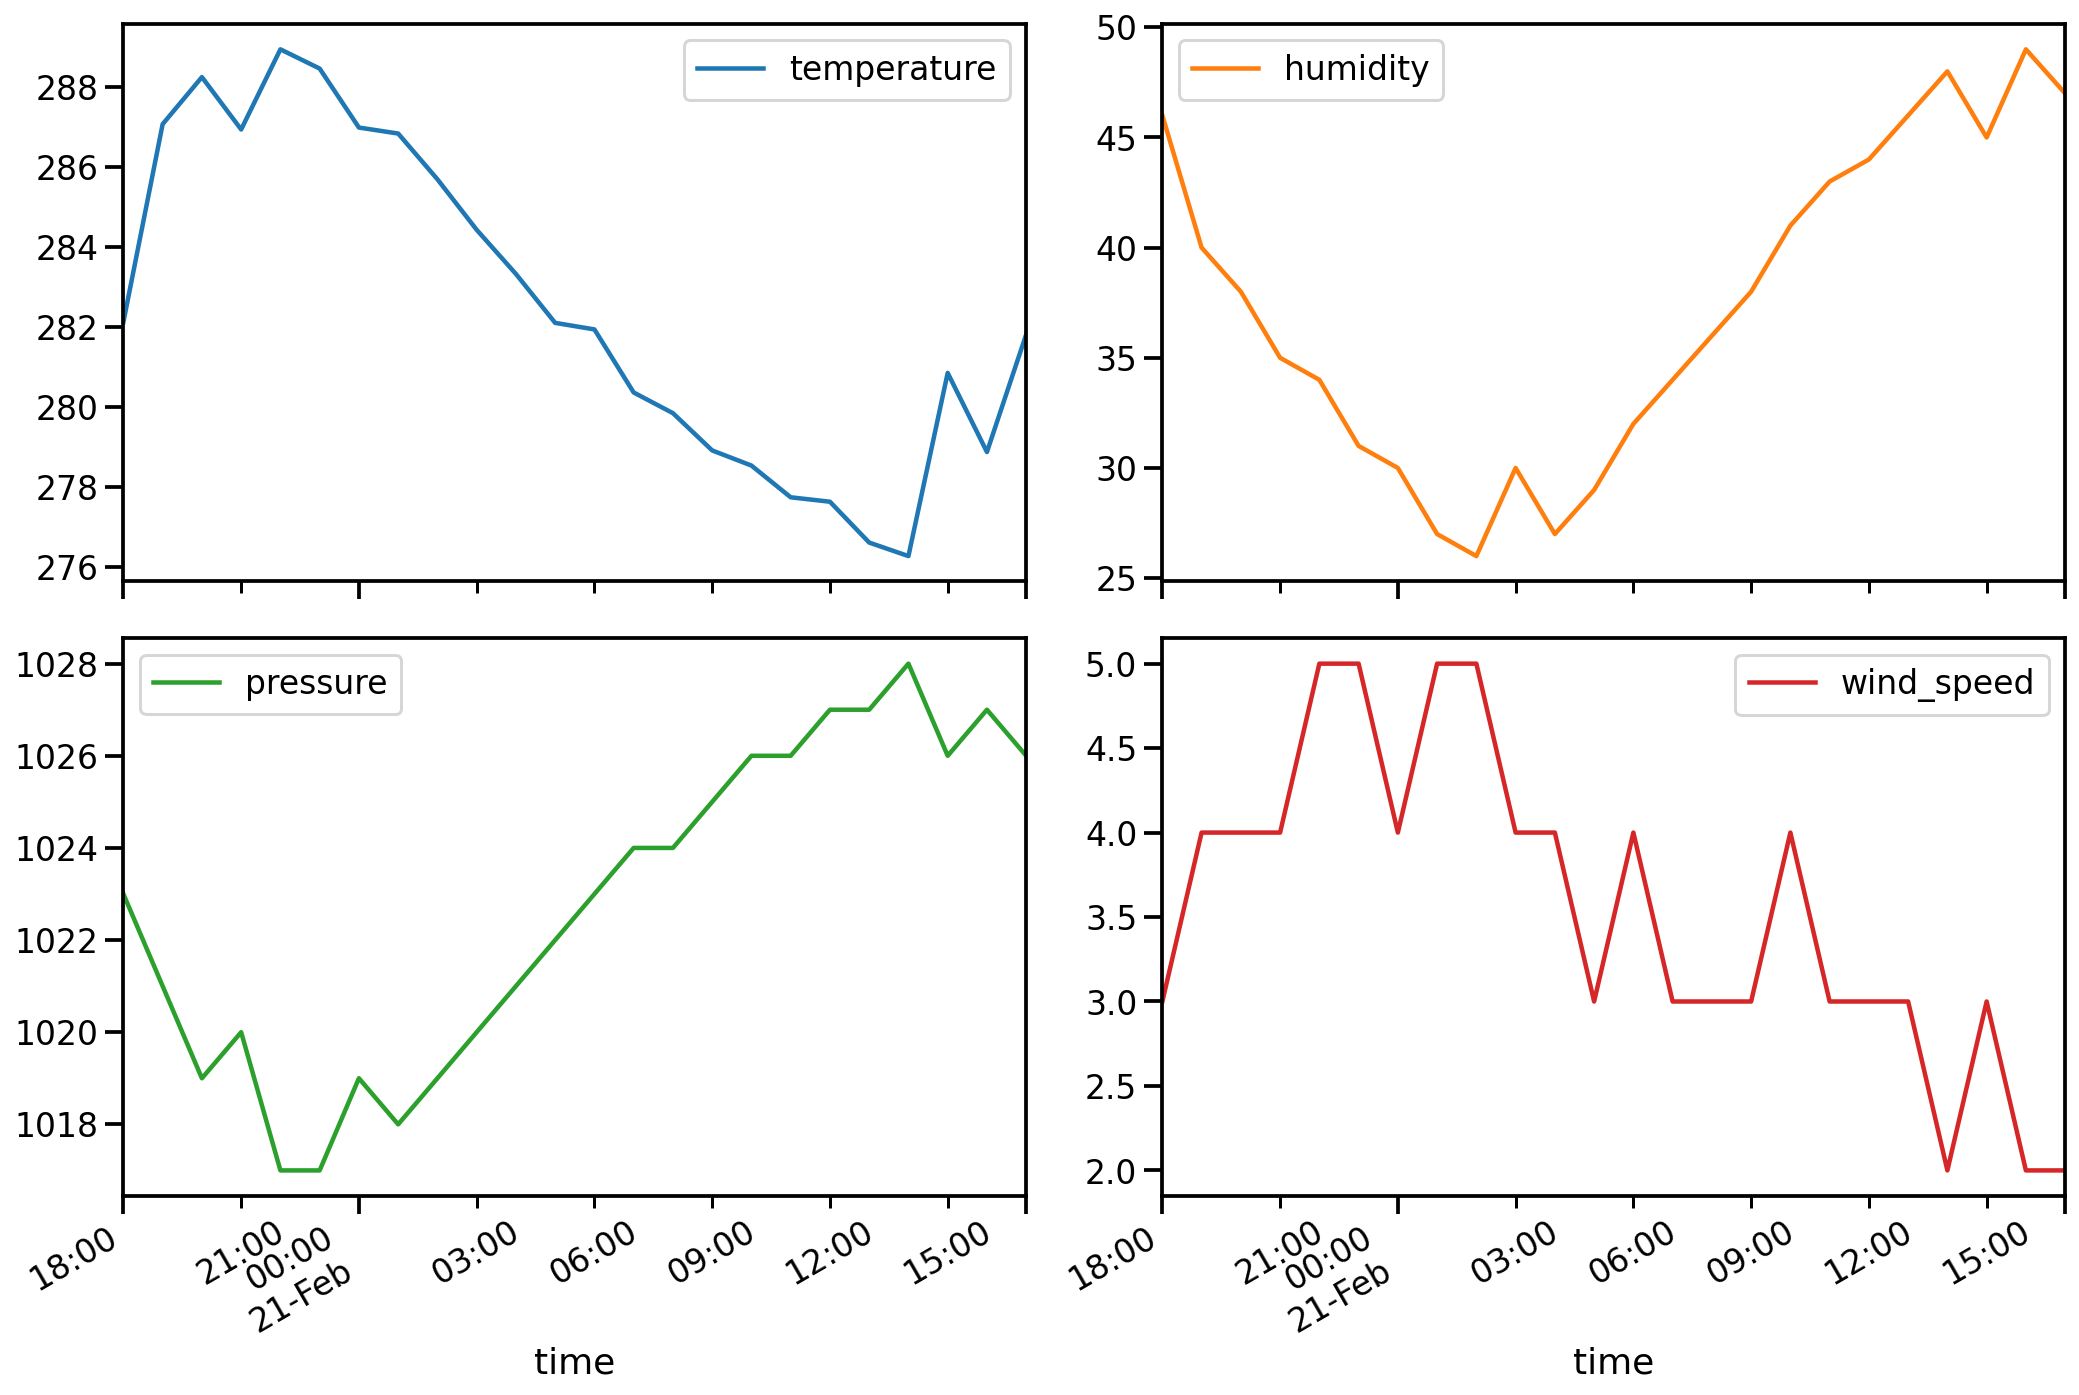

In [9]:
train_X.loc['Albuquerque/1112/1'].plot(subplots=True, layout=(2, 2), figsize=[15, 10])
plt.tight_layout()

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)

scaled_X = {
    'train': scaler.transform(train_X),
    'validate': scaler.transform(validate_X),
    'test': scaler.transform(test_X),
    'score': scaler.transform(score_X),
}

In [11]:
# Keras RNN cells expect inputs with 3 dimensions:
# (batch_size, condition_window, features_length)
# Each RNN cell takes a vector of features_length
# at each time step of condition_window.
# Internal RNN cell state is reset between different batch samples.

# Let's review current shapes of the input, and the desired shapes.

def expected_X_shape(actual_X_shape):
    return (int(actual_X_shape[0]/condition_window), condition_window, features_length)

def expected_y_shape(actual_y_shape):
    return (int(actual_y_shape[0]/prediction_window), prediction_window)


pd.DataFrame({
    'actual shape': [
        train_X.shape, 
        train_y.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
    ],
}, index=['train_X', 'train_y'])

,actual shape,expected shape
train_X,"(826464, 4)","(34436, 24, 4)"
train_y,"(826464, 4)","(34436, 24)"


In [12]:
# Exepected shape can be achieved with a simple reshape call.
# Note that these are not Pandas data frames any more,
# but Numpy n-dimensional arrays.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

def frame_to_ndarray(frame_X, frame_y):
    X_nd = frame_X.reshape(-1, condition_window, features_length).astype('float32')
    y_nd = frame_y['temperature'].values.reshape(-1, prediction_window).astype('float32')
    return X_nd, y_nd

train_X_nd, train_y_nd = frame_to_ndarray(scaled_X['train'], train_y)
validate_X_nd, validate_y_nd = frame_to_ndarray(scaled_X['validate'], validate_y)

# Task: Transform other segments of the dataset (test, and score).
# Enter your code here.

# reshape test and score (can't use function for score set since no y values are available)
test_X_nd, test_y_nd = frame_to_ndarray(scaled_X['test'], test_y)
score_X_nd = scaled_X['score'].reshape(-1, condition_window, features_length).astype('float32')

In [13]:
# let's confirm the expected shapes
pd.DataFrame({
    'initial shape': [
        train_X.shape, 
        train_y.shape,
        validate_X.shape, 
        validate_y.shape,
        test_X.shape, 
        test_y.shape,
        score_X.shape
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape),
        expected_X_shape(validate_X.shape), 
        expected_y_shape(validate_y.shape),
        expected_X_shape(test_X.shape), 
        expected_y_shape(test_y.shape),
        expected_X_shape(score_X.shape)
    ],
    'new shape': [
        train_X_nd.shape, 
        train_y_nd.shape,
        validate_X_nd.shape, 
        validate_y_nd.shape,
        test_X_nd.shape, 
        test_y_nd.shape,
        score_X_nd.shape
    ],
}, index=['train_X', 'train_y', 'validate_X', 'validate_y','test_X', 'test_y','score_X']) # looks good

,initial shape,expected shape,new shape
train_X,"(826464, 4)","(34436, 24, 4)","(34436, 24, 4)"
train_y,"(826464, 4)","(34436, 24)","(34436, 24)"
validate_X,"(54912, 4)","(2288, 24, 4)","(2288, 24, 4)"
validate_y,"(54912, 4)","(2288, 24)","(2288, 24)"
test_X,"(52248, 4)","(2177, 24, 4)","(2177, 24, 4)"
test_y,"(52248, 4)","(2177, 24)","(2177, 24)"
score_X,"(57576, 4)","(2399, 24, 4)","(2399, 24, 4)"


In [57]:
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.layers import Dense, BatchNormalization
from tensorflow.python.keras.models import Sequential
from tensorflow.python import GlorotUniform
from tensorflow.python.keras.regularizers import l1

# IMPORTANT: In order to pass the assignment, you need
# to improve the architecture and/or training procedure of this model.
# You CAN NOT submit the model as is. Please add plain English Python
# comments on how you modified the model and/or training procedure.

# Your work from here forward (please document your code as much as possible)

### RUNNING DOCUMENTATION ###
    # I first added one GRU with 32 units after the initial one and increased initial layer to 64 units
    # summary then showed ~26k total parameters
        # I want to first increase the complexity of the model as much as possible
        # then introduce regularization (l1/l2) and/or reduce the number of units to address overfitting
        # in lecture, we said that <= 60k parameters should be fine from a performance standpoint
        # so, I'll add more layers/units until getting roughly that many parameters
    # I added another 32-unit GRU layer, which resulted in ~33k total parameters
    # so, I increased the unit counts from 64-32-32-16 to 128-64-32-16
        # total parameters went to ~100k --> reduced back to 64-32-32-16
        # added another 32-unit layer --> 64-32-32-32-16 --> ~40k parameters
    # modified to 64-48-32-32-16 --> ~50k parameters --> started testing here
    # severe overfitting --> removed one of the 32-unit layers
    # still overfitting --> introduced l1 kernel, recurent, and bias regularization
    # another method of reducing overfitting that I tried was adding reccurrent dropout, but this didn't help
    # I also tried a bunch of variations of some LSTM models, which I found performed worse on the test set
        
layers = [
        GRU(
            input_shape=(condition_window, features_length),
            units=64,
            return_sequences=True,
            recurrent_activation='sigmoid',
            reset_after=True,
            kernel_initializer=GlorotUniform(seed=42),
            recurrent_initializer=GlorotUniform(seed=43),
            kernel_regularizer=l1(0.01),
            recurrent_regularizer=l1(0.01),
            bias_regularizer=l1(0.01),
        ),
        BatchNormalization(),
        GRU(
            units=48,
            return_sequences=True,
            recurrent_activation='sigmoid',
            reset_after=True,
            kernel_initializer=GlorotUniform(seed=44),
            recurrent_initializer=GlorotUniform(seed=45),
            kernel_regularizer=l1(0.01),
            recurrent_regularizer=l1(0.01),
            bias_regularizer=l1(0.01),
        ),
        BatchNormalization(),
        GRU(
            units=32,
            return_sequences=True,
            recurrent_activation='sigmoid',
            reset_after=True,
            kernel_initializer=GlorotUniform(seed=48),
            recurrent_initializer=GlorotUniform(seed=49),
            kernel_regularizer=l1(0.01),
            recurrent_regularizer=l1(0.01),
            bias_regularizer=l1(0.01),
        ),
        BatchNormalization(),
        GRU(
            units=16,
            return_sequences=False,
            recurrent_activation='sigmoid',
            reset_after=True,
            kernel_initializer=GlorotUniform(seed=50),
            recurrent_initializer=GlorotUniform(seed=51),
            kernel_regularizer=l1(0.01),
            recurrent_regularizer=l1(0.01),
            bias_regularizer=l1(0.01),
        ),
        BatchNormalization(),
        Dense(
            units=prediction_window,
            kernel_initializer=GlorotUniform(seed=52),
            activation='linear'
        )
]

model = Sequential(layers)

In [58]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_46 (GRU)                 (None, 24, 64)            13440     
_________________________________________________________________
batch_normalization_46 (Batc (None, 24, 64)            256       
_________________________________________________________________
gru_47 (GRU)                 (None, 24, 48)            16416     
_________________________________________________________________
batch_normalization_47 (Batc (None, 24, 48)            192       
_________________________________________________________________
gru_48 (GRU)                 (None, 24, 32)            7872      
_________________________________________________________________
batch_normalization_48 (Batc (None, 24, 32)            128       
_________________________________________________________________
gru_49 (GRU)                 (None, 16)              

In [59]:
from utils import r2_score, mean_error
from tensorflow.keras.optimizers import Adam

# IMPORTANT: In order to pass the assignment, you need
# to improve the architecture and/or training procedure of this model.
# You CAN NOT submit the model as is. Please add plain English Python
# comments on how you modified the model and/or training procedure.

### RUNNING DOCUMENTATION ###
    # I increased the learning rate by a factor of 5 (0.01 --> 0.05)
    # this is because we have functionality (below) that will reduce the learning rate on a plateau
    # we can also plot the learning curve to get an idea of how to tweak the learning rate

    # the learning curve showed that validation loss was way higher than training loss with lr=0.05
    # so, I changed it to 0.005
    # after adjusting the architecture, I moved back to 0.01
    # failing to learn --> 0.001

model.compile(
    optimizer=Adam(lr=0.001),
    loss='mean_squared_error',
    metrics=[
        'mean_absolute_error',
        r2_score,
        mean_error
    ]
)

In [60]:
%%time

from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

# IMPORTANT: In order to pass the assignment, you need
# to improve the architecture and/or training procedure of this model.
# You CAN NOT submit the model as is. Please add plain English Python
# comments on how you modified the model and/or training procedure.

### RUNNING DOCUMENTATION ###
    # in order to give the dynamic learning rate functionality a chance to actually enhance the learning process
    # we need to use a number of training epochs that is high relative to the ReduceLROnPlateau patience
    # since we started with a patience of 3 in ReduceLROnPlateau
    # we'll use 30 training epochs (might need more)
    # I set early stopping patience to 6
    # this will stop the learning process if the LR reduction is insufficient to overcome the stagnation in learning

    # I also modified EarlyStopping to monitor val_loss
    # this is because the actual loss is not representative of the kind of learning that we actually care about

    # if we find that the learning rate is dropping off too quickly and the model is getting stuck in local minima
    # then maybe we can decrease the min delta in the various callbacks functions or the factor parameter
    # but we'll start with the default values

history = model.fit(
    train_X_nd,
    train_y_nd,
    validation_data=(validate_X_nd, validate_y_nd),
    epochs=30,
    batch_size=100,
    callbacks=[
        TerminateOnNaN(),
        ReduceLROnPlateau(
            monitor='loss',
            min_delta=0.1,
            patience=3,
            cooldown=10,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            min_delta=0.1,
            patience=6
        )
    ]
)

Epoch 1/30
345/345 [==============================] - 95s 275ms/step - loss: 81982.0703 - mean_absolute_error: 286.1792 - r2_score: -610.0878 - mean_error: -286.1715 - val_loss: 77535.6797 - val_mean_absolute_error: 278.3568 - val_r2_score: -2874.2952 - val_mean_error: -278.3330 - lr: 0.0010
Epoch 2/30
345/345 [==============================] - 96s 277ms/step - loss: 76523.1719 - mean_absolute_error: 276.5406 - r2_score: -569.9476 - mean_error: -276.5253 - val_loss: 71925.6328 - val_mean_absolute_error: 268.1325 - val_r2_score: -2649.4136 - val_mean_error: -268.1201 - lr: 0.0010
Epoch 3/30
345/345 [==============================] - 93s 270ms/step - loss: 66655.9062 - mean_absolute_error: 258.0417 - r2_score: -496.0224 - mean_error: -258.0191 - val_loss: 61048.4844 - val_mean_absolute_error: 247.0170 - val_r2_score: -2246.5435 - val_mean_error: -247.0061 - lr: 0.0010
Epoch 4/30
345/345 [==============================] - 94s 273ms/step - loss: 54231.1797 - mean_absolute_error: 232.6666 -

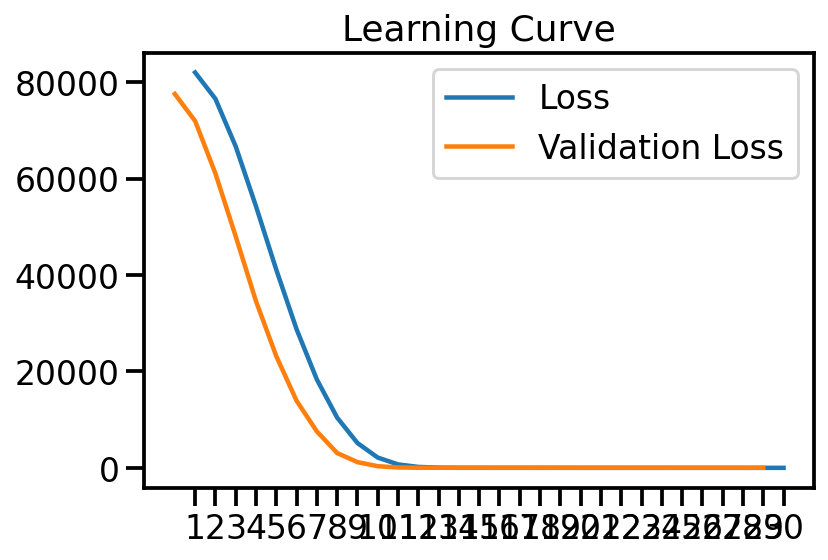

In [64]:
import numpy as np

# plot learning curves for learning rate diagnostics
lcurve_loss = pd.Series(history.history['loss'])
lcurve_val_loss = pd.Series(history.history['val_loss'])
lcurve_loss.index = lcurve_loss.index + 1

lcurve_loss.plot(title='Learning Curve', label='Loss')
lcurve_val_loss.plot(title='Learning Curve', label='Validation Loss')

# I found that taking the log of these arrays made the learning curves easier to visually interpret
# since some of the values were quite extreme
# plt.plot(np.log(lcurve_loss), label='Loss')
# plt.plot(np.log(lcurve_val_loss), label='Val Loss')

plt.legend()
plt.xticks(lcurve_loss.index)
plt.show()

In [70]:
# Note that Keras evaluates metrics in batches,
# which is okay for averaging-stable metrics like ME, MSE, and MAE,
# but R2 requires full dataset to evaluate precisely.

# This implies two things:
# 1) R2 as reported during training is not precise
# 2) when evaluating R2 after training, batch size must match dataset size

nd_array_by_segment = {
    'train': (train_X_nd, train_y_nd),
    'validate': (validate_X_nd, validate_y_nd),
    'test': (test_X_nd, test_y_nd)
}

metrics_by_segment = {
    segment: model.evaluate(
        X_nd, 
        y_nd, 
        verbose=0, 
        batch_size=X_nd.shape[0]
    )
    for segment, (X_nd, y_nd) in nd_array_by_segment.items()
}

rnn_metrics = pd.concat([
    pd.DataFrame(
        data=[metrics], 
        columns=['MSE', 'MAE', 'R2', 'ME'], 
        index=[segment]
    )
    for segment, metrics in metrics_by_segment.items()
])

rnn_metrics = pd.DataFrame([rnn_metrics.unstack()], index=['rnn'])\
    .swaplevel(axis=1, i=0, j=1)\
    .reindex(nd_array_by_segment.keys(), axis=1, level=0)\
    .round(2)

rnn_metrics

train                  validate                    test                  
       MSE   MAE   R2    ME      MSE  MAE    R2    ME    MSE   MAE    R2    ME
rnn  15.82  2.72  0.9  0.14    22.31  3.3  0.78 -0.53  16.54  2.83  0.81  0.15

In [71]:
from utils import SegmentDataset, baseline_metrics

segment_names = ['train', 'validate', 'test']
panel_dataset = SegmentDataset.from_pq_workdir(prefix, segment_names, ['x', 'y'])
baseline_metrics = baseline_metrics(panel_dataset)

In [72]:
pd.concat([
    baseline_metrics,
    rnn_metrics
], axis=0).loc[:, (slice(None), ['MSE', 'R2'])].round(2)

test        train       validate      
              MSE    R2    MSE    R2      MSE    R2
mean        28.52  0.61  26.77  0.80    37.23  0.58
constant    20.20  0.72  21.82  0.84    40.25  0.54
regression  33.64  0.54  30.53  0.78    29.94  0.66
rnn         16.54  0.81  15.82  0.90    22.31  0.78

In [78]:
# check that model is making precictions correctly
from sklearn.metrics import r2_score, mean_squared_error
train_y_pred = model.predict(train_X_nd)
print(r2_score(train_y_nd, train_y_pred))
val_y_pred = model.predict(validate_X_nd)
print(r2_score(validate_y_nd, val_y_pred))
test_y_pred = model.predict(test_X_nd)
print(r2_score(test_y_nd, test_y_pred))


0.9040353385019003
0.7760158165810105
0.8100826851279043


/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() inst

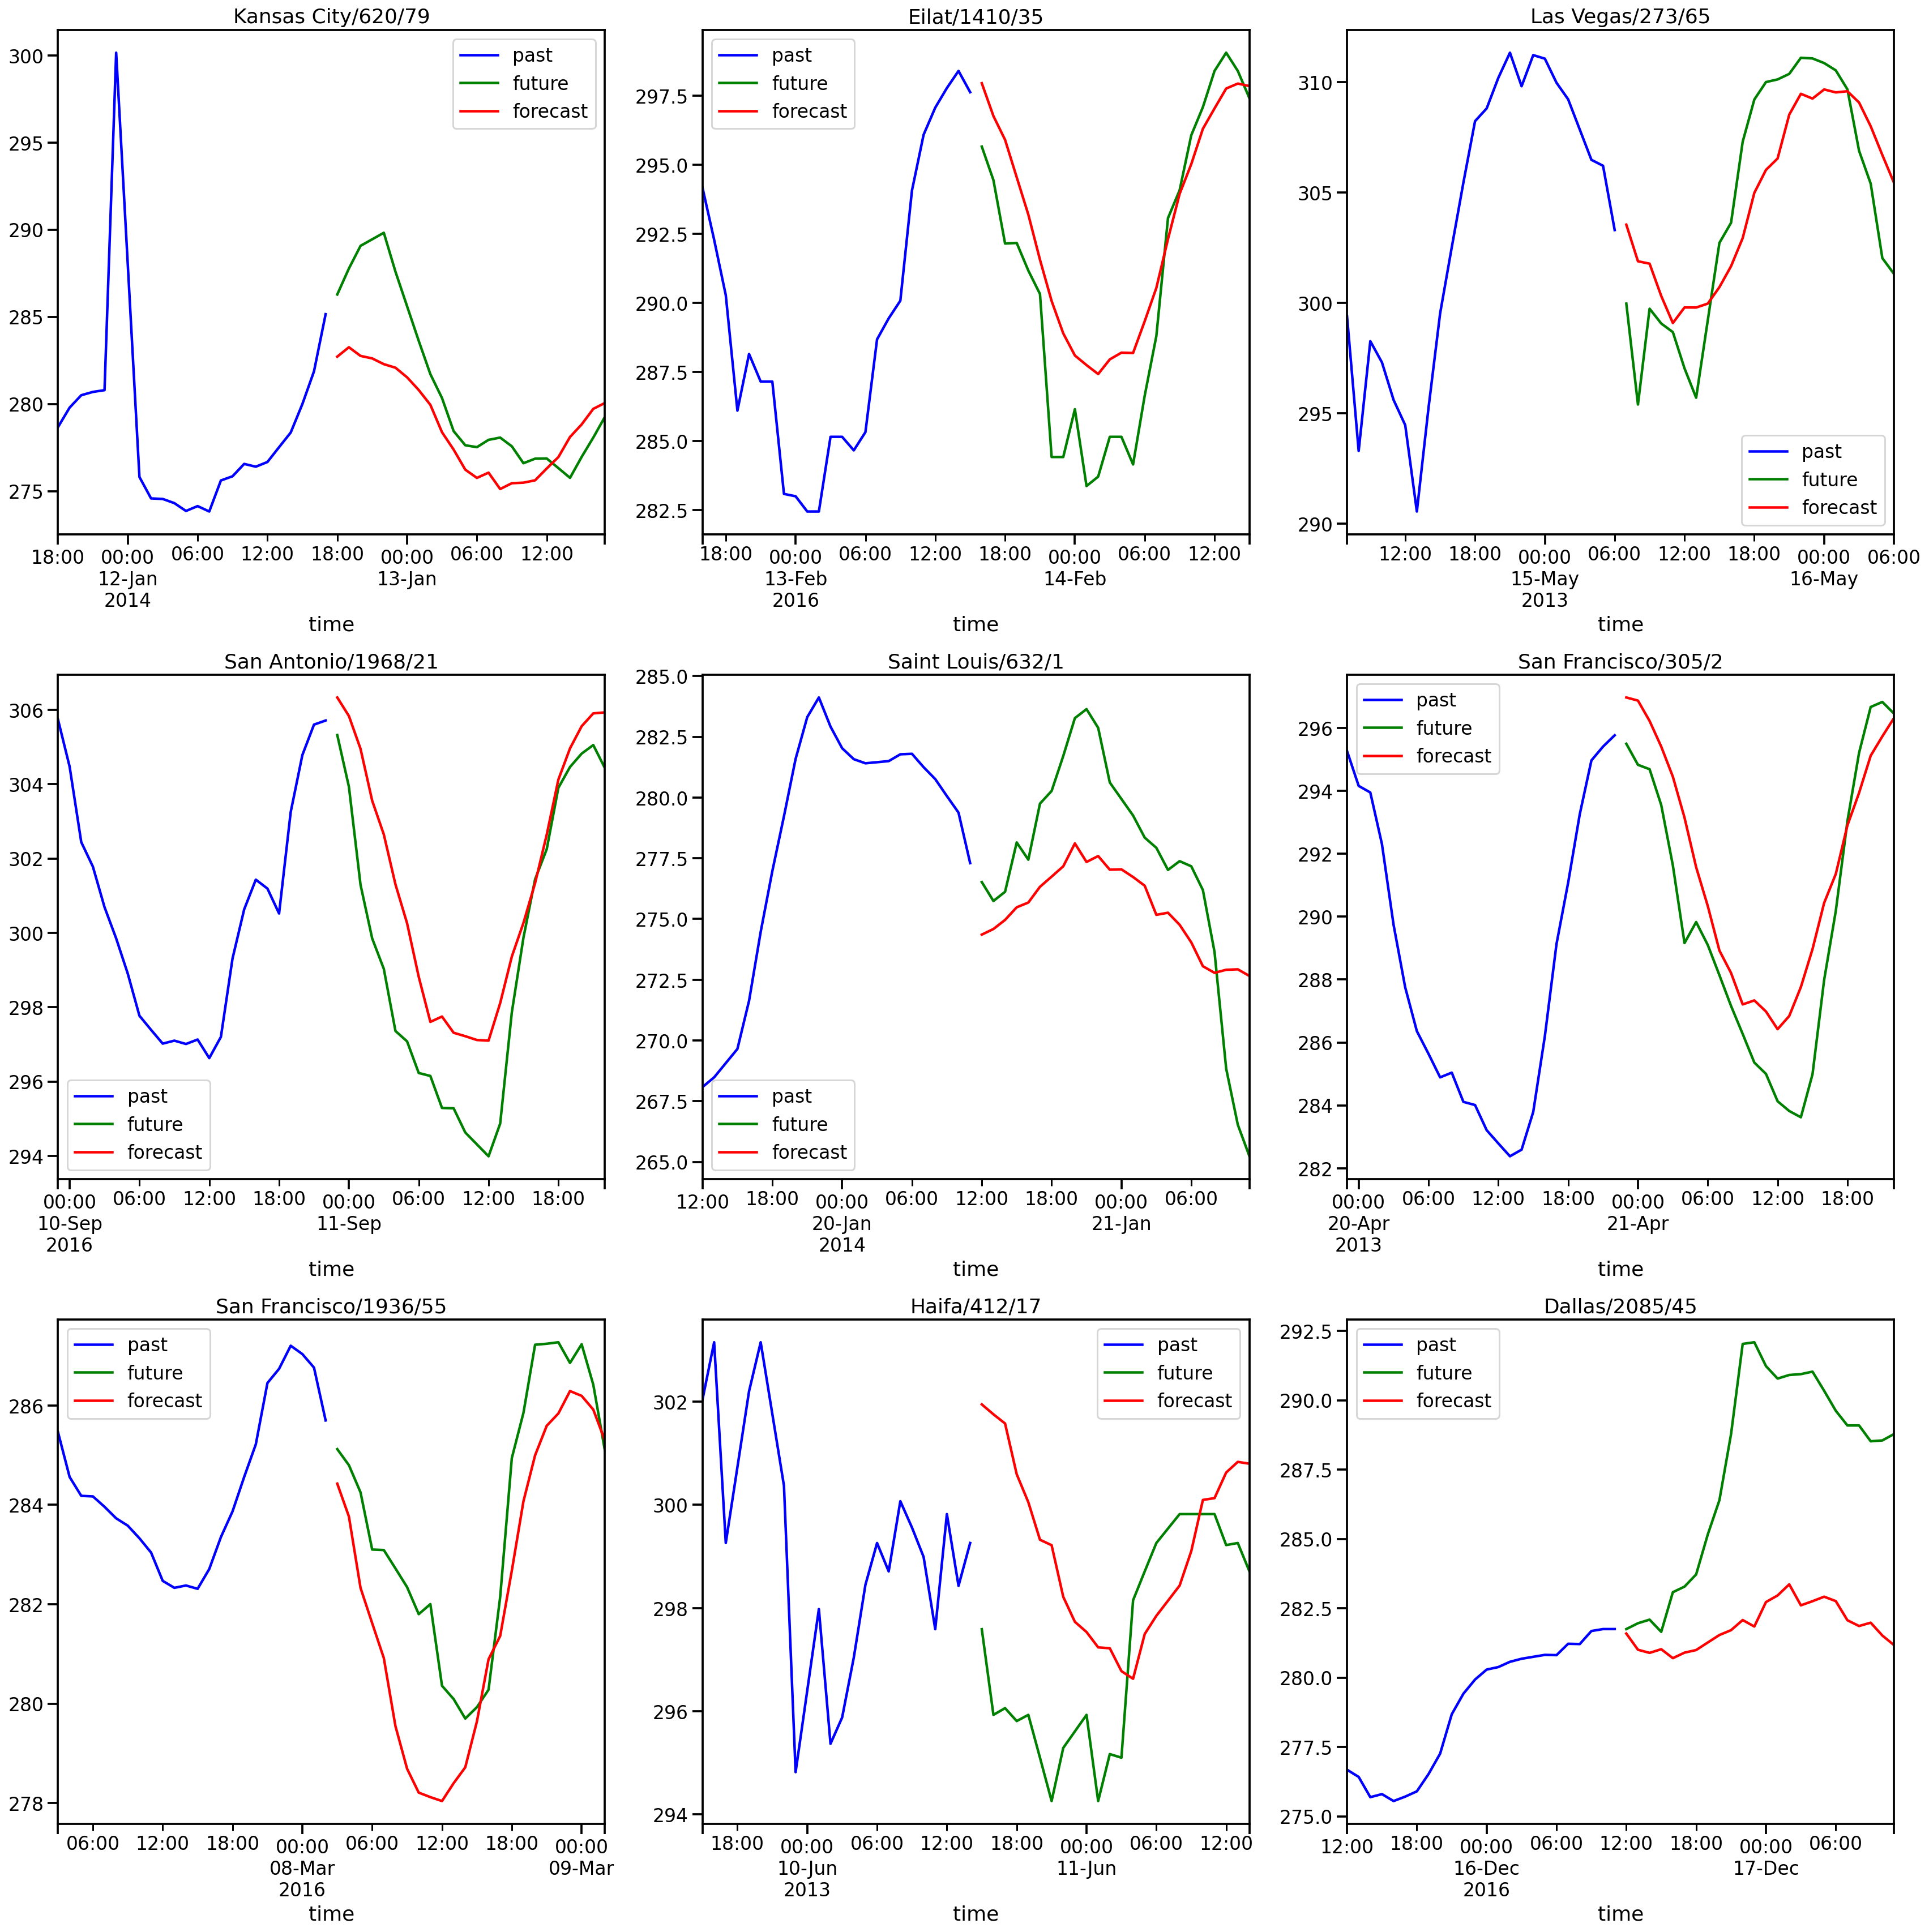

In [73]:
from utils import nd_target_like_panel, plot_random_forecasts

train_y_hat = nd_target_like_panel(train_y, model.predict(train_X_nd))

plot_random_forecasts(
    train_X['temperature'],
    train_y['temperature'],
    train_y_hat.rename(columns={'temperature': 'forecast'})
)

In [92]:
# TO DO: save your predictions on the Score segment as a Pandas data frame
# into a variable named score_y_hat.
score_y_hat = model.predict(score_X_nd)

# Keras model will output an array of shape (2399, 24) for the Score segment,
# however the expected shape of the submitted data frame is (57576, 1).
# 57576 = 2399 (count of samples in Score segment) x 24 (prediction window).
# Use NumPy's reshape() or ravel() functions to achieve this.
score_y_hat = np.reshape(score_y_hat, (57576, 1))

# Finally, the data frame needs to have string column names in order to be saved
# as a Parquet file. If you convert a NumPy array to Pandas data frame,
# column names will be integers, but you can replace the column names.
# There was a similar example of this in the notebook from the first assignment.
score_y_hat = pd.DataFrame(score_y_hat, columns=['temperature'])
# expected output: (Index(['temperature'], dtype='object'), (57576, 1))
score_y_hat.columns, score_y_hat.shape

(Index(['temperature'], dtype='object'), (57576, 1))

In [93]:
# Once you are satisfied with your model,
# your need to submit 4 files:
# 1. this notebook and/or any other Python scripts
# 2. Model definition in JSON format
# 3. Model parameters in H5 format
# 4. temperature forecast for the Score segment

import os
model_dir = 'weathernet_model'
os.makedirs(model_dir, exist_ok=True)

# Save model definition:
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    model_json = json.dumps(json.loads(model.to_json()), indent=True)
    f.write(model_json)

# Save the learned parameters.
model.save_weights(f"{model_dir}/keras_parameters.h5")

# Finally, let's save the forecast.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')